In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Machine learning packages
from sklearn import linear_model
from sklearn import feature_selection as fs
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Predicting Housing Prices in Melbourne, Australia

So what factors go into determining housing prices, anyways? Some obvious factors might be the dimensions of the property, the year it was built, and the location. To further explore this question, and predict what house prices will be based on factors like these, we'll be using a dataset for Melbourne, Australia to construct a predictive model.

In [ ]:
# Grab and process the raw data.
melbourne = pd.read_csv('data\\Melbourne_housing_FULL.csv')

# Data Processing

In [2]:
# Preview our dataset
melbourne.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.5,3067.0,...,1.0,1.0,126.0,NaN,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,4/02/2016,2.5,3067.0,...,2.0,1.0,0.0,NaN,NaN,Yarra City Council,-37.8114,145.0116,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0


In [3]:
# Viewing the size of our original dataframe
melbourne.shape

(34857, 21)

In [4]:
# Drops all rows with NaN
melbourne = melbourne.dropna(0)

# Removes rows where the price is NaN since we can't predict the value
# melbourne = melbourne[pd.notnull(melbourne['Price'])]

# Drop removing rows with NaN
# melbourne = melbourne.dropna(0)

# Viewing the size of our dataframe after dropping nulls
melbourne.shape

(8887, 21)

Unfortunately, we have null values in our dataset and by removing them, we also remove roughly 75% of the data, not at random.

In [5]:
# Looking at the type of data in our dataset
melbourne.dtypes

Suburb            object
Address           object
Rooms              int64
Type              object
Price            float64
Method            object
SellerG           object
Date              object
Distance         float64
Postcode         float64
Bedroom2         float64
Bathroom         float64
Car              float64
Landsize         float64
BuildingArea     float64
YearBuilt        float64
CouncilArea       object
Lattitude        float64
Longtitude       float64
Regionname        object
Propertycount    float64
dtype: object

In [6]:
# Print out the number of unique columns in our categorical variables
categorical = melbourne.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i)
    print(column.nunique())

Suburb
315
Address
8764
Type
3
Method
5
SellerG
250
Date
77
CouncilArea
33
Regionname
8


We have quite a few categorical columns, but some of them contain too many unique values that will most likely slow down our model, and reduce its predictive accuracy. In order to create a cutoff point for excess features, we will be dropping every column with over 10 unique values.

In [7]:
# Examining the data
melbourne.describe()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,8887.000000,8.887000e+03,8887.000000,8887.000000,8887.000000,8887.000000,8887.000000,8887.000000,8887.000000,8887.000000,8887.000000,8887.000000,8887.000000
mean,3.098909,1.092902e+06,11.199887,3111.662653,3.078204,1.646450,1.692247,523.480365,149.309477,1965.753348,-37.804501,144.991393,7475.940137
std,0.963786,6.793819e+05,6.813402,112.614268,0.966269,0.721611,0.975464,1061.324228,87.925580,37.040876,0.090549,0.118919,4375.024364
min,1.000000,1.310000e+05,0.000000,3000.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1196.000000,-38.174360,144.423790,249.000000
25%,2.000000,6.410000e+05,6.400000,3044.000000,2.000000,1.000000,1.000000,212.000000,100.000000,1945.000000,-37.858560,144.920000,4382.500000
50%,3.000000,9.000000e+05,10.200000,3084.000000,3.000000,2.000000,2.000000,478.000000,132.000000,1970.000000,-37.798700,144.998500,6567.000000
75%,4.000000,1.345000e+06,13.900000,3150.000000,4.000000,2.000000,2.000000,652.000000,180.000000,2000.000000,-37.748945,145.064560,10331.000000
max,12.000000,9.000000e+06,47.400000,3977.000000,12.000000,9.000000,10.000000,42800.000000,3112.000000,2019.000000,-37.407200,145.526350,21650.000000


In [8]:
# Setting up a dataframe for our predictors
X = melbourne.drop(['Price', 'Suburb', 'Address', 'SellerG', 'Date'], axis=1)
X = pd.get_dummies(X)

# Create a series with the variable we want to predict, price
y = melbourne['Price']

In [9]:
# Preview the data after data cleaning, and creating dummy variables
X.head()

,Rooms,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,...,CouncilArea_Yarra City Council,CouncilArea_Yarra Ranges Shire Council,Regionname_Eastern Metropolitan,Regionname_Eastern Victoria,Regionname_Northern Metropolitan,Regionname_Northern Victoria,Regionname_South-Eastern Metropolitan,Regionname_Southern Metropolitan,Regionname_Western Metropolitan,Regionname_Western Victoria
2,2,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,-37.8079,...,1,0,0,0,1,0,0,0,0,0
4,3,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,-37.8093,...,1,0,0,0,1,0,0,0,0,0
6,4,2.5,3067.0,3.0,1.0,2.0,120.0,142.0,2014.0,-37.8072,...,1,0,0,0,1,0,0,0,0,0
11,3,2.5,3067.0,4.0,2.0,0.0,245.0,210.0,1910.0,-37.8024,...,1,0,0,0,1,0,0,0,0,0
14,2,2.5,3067.0,2.0,1.0,2.0,256.0,107.0,1890.0,-37.8060,...,1,0,0,0,1,0,0,0,0,0


(0, 5000000)

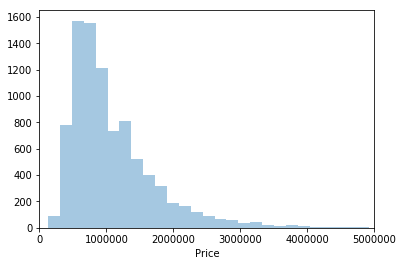

In [31]:
# View histogram of price data
sns.distplot(y, kde=False)
plt.xlim(0,5000000)

In [19]:
y.describe()

count    8.887000e+03
mean     1.092902e+06
std      6.793819e+05
min      1.310000e+05
25%      6.410000e+05
50%      9.000000e+05
75%      1.345000e+06
max      9.000000e+06
Name: Price, dtype: float64

In [10]:
# Split data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Multivariable regression model



In [13]:
# Constructing a simple linear model
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

# Inspect the results.
cross_val_score(regr, X_test, y_test, cv=5)

array([0.68768564, 0.71645594, 0.66401593, 0.71539897, 0.68958849])

In [32]:
y_pred = reg.predict(X_test)
sns.distplot(y_pred, kde=False)
plt.xlim(0,5000000)

NameError: name 'lr' is not defined

# Fine tuning the model

In [14]:
kbest = SelectKBest(f_classif, k=10)
X_train = kbest.fit_transform(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [43] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [15]:
# Constructing a simple linear model
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

# Inspect the results.
print(cross_val_score(regr, X_test, y_test, cv=5))

[0.68768564 0.71645594 0.66401593 0.71539897 0.68958849]


In [16]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=10)
X = StandardScaler().fit_transform(X)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 
                          'principal component 5', 'principal component 6', 'principal component 7', 'principal component 8', 
                          'principal component 9', 'principal component 10'])

X = principalDf

In [17]:
# Create training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5)

# Constructing a simple linear model
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

# Inspect the results.
print(cross_val_score(regr, X_test, y_test, cv=5))

[0.5921037  0.57511827 0.60220414 0.65733489 0.52844481]
